Projet de prédiction de données electrique 

1)Importation des bibilothèques d'intérets

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sklearn
import pickle as pkl
import math
from sklearn.svm import SVR
from sklearn.neighbors import  KNeighborsRegressor
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.linear_model import RidgeCV
from sklearn import model_selection
from sklearn import neighbors, metrics
from sklearn import preprocessing

2) Ouverture Données des consommateurs

In [2]:
df=pd.read_pickle('Irish_synchrone_sample6_train.pkl')
# On supprime les données nulles
df.dropna()

df2=pd.read_pickle('Irish_synchrone_sample6_to_predict_na.pkl')

df

,mean,TempMean,TempMin,TempMax,WindSpeed,WindSpeedMaxS,WindSpeedMaxG,Precip,Time,Posan,Instant
Date,,,,,,,,,,,
2010-01-01 00:00:00,0.737459,29.1,24.8,33.8,8.3,12.0,999.9,0.11,8210,1,48
2010-01-01 00:30:00,0.682706,29.1,24.8,33.8,8.3,12.0,999.9,0.11,8211,1,1
2010-01-01 01:00:00,0.608187,29.1,24.8,33.8,8.3,12.0,999.9,0.11,8212,1,2
2010-01-01 01:30:00,0.538792,29.1,24.8,33.8,8.3,12.0,999.9,0.11,8213,1,3
2010-01-01 02:00:00,0.458989,29.1,24.8,33.8,8.3,12.0,999.9,0.11,8214,1,4
...,...,...,...,...,...,...,...,...,...,...,...
2010-12-14 21:30:00,0.954564,36.0,28.4,41.5,6.2,8.0,999.9,0.00,24909,347,43
2010-12-14 22:00:00,0.900292,36.0,28.4,41.5,6.2,8.0,999.9,0.00,24910,347,44
2010-12-14 22:30:00,0.877204,36.0,28.4,41.5,6.2,8.0,999.9,0.00,24911,347,45


Coup d'oeil sur les différentes colonnes du dataframe pour trouver quelles sonnées sont pertinentes à utiliser

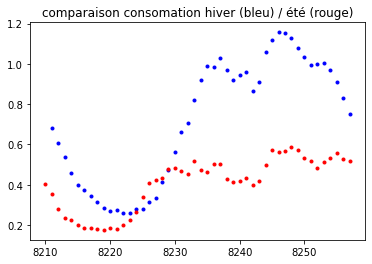

In [3]:
plt.plot(df['Time'][1:48],df['mean'][1:48],'b.')
plt.plot(df['Time'][0:48],df['mean'][180*48:181*48],'r.')
plt.title("comparaison consomation hiver (bleu) / été (rouge)")
plt.show()

On remarque une différence nette entre l'été et l'hiver pour prédire la consommation électrique durant la deuxième moitié de décembre, on va donc plutôt entraîner notre algorithme sur des journées d'hiver.

In [4]:
n=270
m=75
T=[]

for i in np.linspace(1,48,70):
    T.append([i,36,0.5,12])


x=[]
for i in range(1,m*48-1):
    x.append([df['Instant'][i],df['TempMean'][i],df['Precip'][i],df['WindSpeed'][i]])
for i in range(n*48,(n+m)*48-1):
    x.append([df['Instant'][i],df['TempMean'][i],df['Precip'][i],df['WindSpeed'][i]])

Y=np.concatenate((np.array(df['mean'][1:m*48-1]),np.array(df['mean'][n*48:(n+m)*48-1])))

model_SVR=SVR(kernel='rbf',gamma='auto')

#Séparation des données en 4 listes avec des données test de 20%
X_train, X_test, Y_train, Y_test = train_test_split(x,Y,test_size=0.2)

# Entrainement
model_SVR.fit(X_train,Y_train.ravel())

# Score
print(model_SVR.score(X_test,Y_test))


0.888932141135623


On débute par l'algorithme de regression SVR avec ici seulement 4 features pour notre x d'entrée. On l'entraine sur les 75 derniers jours avant le 15 décembre et les 75 jours du début de l'année pour l'entrainer sur des journées d'hiver uniquement (janvier à mi-mars et octobre à mi-décembre). On gardera cette période d'entrainement des algortihmes tout le long de l'étude. 

In [5]:
from sklearn.svm import SVR

n=270
m=75
T=[]

for i in np.linspace(1,48,70):
    T.append([i,36,0.5,8])

x=[]
for i in range(1,m*48-1):
    x.append([df['Instant'][i],df['TempMean'][i],df['Precip'][i],df['WindSpeed'][i],df['TempMin'][i],df['TempMax'][i]])
for i in range(n*48,(n+m)*48-1):
    x.append([df['Instant'][i],df['TempMean'][i],df['Precip'][i],df['WindSpeed'][i],df['TempMin'][i],df['TempMax'][i]])

Y=np.concatenate((np.array(df['mean'][1:m*48-1]),np.array(df['mean'][n*48:(n+m)*48-1])))

model_SVR2=SVR(kernel='rbf',gamma='auto')

from sklearn.model_selection import train_test_split
#Séparation des données en 4 listes avec des données test de 20%
X_train, X_test, Y_train, Y_test = train_test_split(x,Y,test_size=0.2)

model_SVR2.fit(X_train,Y_train.ravel())

print(model_SVR2.score(X_test,Y_test))


0.8816387235650068


On a augmenté ici de 2 features en ajoutant les températures extrèmes et le score diminue, ce n'est donc pas pertinent pour ce modèle

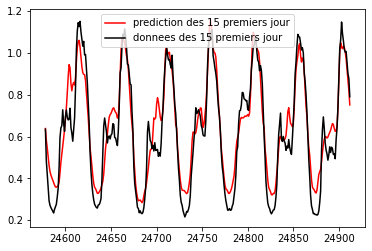

In [6]:
donne_dec=[]
for i in range(len(df['Instant'][-336:-1])):
    donne_dec.append([df['Instant'][i],df['TempMean'][i],df['Precip'][i],df['WindSpeed'][i]])

pred=model_SVR.predict(donne_dec)
plt.plot(df['Time'][-336:-1],pred,'r',label='prediction des 15 premiers jour')
plt.plot(df['Time'][-336:-1],df['mean'][-336:-1],'k',label='donnees des 15 premiers jour')
plt.legend()
plt.show()

On prédit les 15 premiers jours de décembre avec ce modèle et on le compare avec les donées réelles pour se rendre compte. On a des approximations aux maximas et aux zone de perturbartions au milieu de la journée

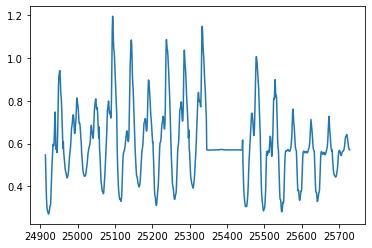

In [7]:
donne=[]
for i in range(len(df2['Instant'])):
    donne.append([df2['Instant'][i],df2['TempMean'][i],df2['Precip'][i],df2['WindSpeed'][i]])

Prediction=model_SVR.predict(donne)

plt.plot(df2['Time'],Prediction)
plt.show()


On a ici essayé de prédire les donner des 15 derniers jours de décembre et il y a des jours avec des températures très basses qui font ne plus fonctionner le modèle. Le modèle n'ayant jamais eu à faire à des températures aussi basses, n'arrive pas à donner une bonne prédiction. Il faut donc trouver un autre algorithme de prédiction

In [8]:
df2[-370:-330]

,mean,TempMean,TempMin,TempMax,WindSpeed,WindSpeedMaxS,WindSpeedMaxG,Precip,Time,Posan,Instant
Date,,,,,,,,,,,
2010-12-24 07:00:00,NaN,18.6,12.2,23.5,9.6,13.6,999.9,0.12,25360,357,14
2010-12-24 07:30:00,NaN,18.6,12.2,23.5,9.6,13.6,999.9,0.12,25361,357,15
2010-12-24 08:00:00,NaN,18.6,12.2,23.5,9.6,13.6,999.9,0.12,25362,357,16
2010-12-24 08:30:00,NaN,18.6,12.2,23.5,9.6,13.6,999.9,0.12,25363,357,17
2010-12-24 09:00:00,NaN,18.6,12.2,23.5,9.6,13.6,999.9,0.12,25364,357,18
2010-12-24 09:30:00,NaN,18.6,12.2,23.5,9.6,13.6,999.9,0.12,25365,357,19
2010-12-24 10:00:00,NaN,18.6,12.2,23.5,9.6,13.6,999.9,0.12,25366,357,20
2010-12-24 10:30:00,NaN,18.6,12.2,23.5,9.6,13.6,999.9,0.12,25367,357,21
2010-12-24 11:00:00,NaN,18.6,12.2,23.5,9.6,13.6,999.9,0.12,25368,357,22


In [9]:
n=270
m=75

x=[]
for i in range(1,m*48-1):
    x.append([df['Instant'][i],df['TempMean'][i],df['Precip'][i],df['WindSpeed'][i]])
for i in range(n*48,(n+m)*48-1):
    x.append([df['Instant'][i],df['TempMean'][i],df['Precip'][i],df['WindSpeed'][i]])

Y=np.concatenate((np.array(df['mean'][1:m*48-1]),np.array(df['mean'][n*48:(n+m)*48-1])))

#On centre et réduit les données d'enréesdu modèle car c'est nécessaire dans le cadre de KNN
scal_donne_dec=StandardScaler()
Scaler_donne_dec = scal_donne_dec.fit(x)
x_scaled = scal_donne_dec.transform(x)

#On pose le modèle KNN avec 5 voisin
neigh1=KNeighborsRegressor(n_neighbors=5, weights="uniform")

from sklearn.model_selection import train_test_split
#Séparation des données en 4 listes avec des données test de 20%
X_train, X_test, Y_train, Y_test = train_test_split(x_scaled,Y,test_size=0.2)

neigh1.fit(X_train,Y_train)

print(neigh1.score(X_test,Y_test))

0.9424277219627558


On tente donc l'algorithme de régression par le KNN avec 5 voisins pour commencer

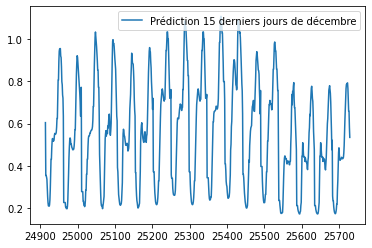

In [10]:
donne=[]
for i in range(len(df2['Instant'])):
    donne.append([df2['Instant'][i],df2['TempMean'][i],df2['Precip'][i],df2['WindSpeed'][i]])

scal_donne_dec=StandardScaler()
Scaler_donne_dec = scal_donne_dec.fit(donne)
donne_dec_scaled = scal_donne_dec.transform(donne)

Prediction=neigh1.predict(donne_dec_scaled)

plt.plot(df2['Time'],Prediction,label='Prédiction 15 derniers jours de décembre')
plt.legend()
plt.show()

On test tout de suite ce qui nous a limité sur le modèle SVR et les basses températures ne sont a sune limites pour KNN. On va donc garder ce modèle et l'optimiser

In [11]:
from sklearn.neighbors import  KNeighborsRegressor

n=270
m=75

x=[]
for i in range(1,m*48-1):
    x.append([df['Instant'][i],df['TempMean'][i],df['Precip'][i],df['WindSpeed'][i],df['TempMin'][i]])
for i in range(n*48,(n+m)*48-1):
    x.append([df['Instant'][i],df['TempMean'][i],df['Precip'][i],df['WindSpeed'][i],df['TempMin'][i]])

Y=np.concatenate((np.array(df['mean'][1:m*48-1]),np.array(df['mean'][n*48:(n+m)*48-1])))

scal_donne_dec=StandardScaler()
Scaler_donne_dec = scal_donne_dec.fit(x)
x_scaled = scal_donne_dec.transform(x)

neigh2=KNeighborsRegressor(n_neighbors=3, weights="uniform")

X_train, X_test, Y_train, Y_test = train_test_split(x_scaled,Y,test_size=0.2)

neigh2.fit(X_train,Y_train)

print(neigh2.score(X_test,Y_test))

0.9508613176059292


On ajoute TempMin et passe à 3 voisins ( cela a été fait à osteriori et justifié à la fin du projet)

In [12]:
n=270
m=75

x=[]
for i in range(1,m*48-1):
    x.append([df['Instant'][i],df['TempMean'][i],df['Precip'][i],df['WindSpeed'][i],df['TempMax'][i]])
for i in range(n*48,(n+m)*48-1):
    x.append([df['Instant'][i],df['TempMean'][i],df['Precip'][i],df['WindSpeed'][i],df['TempMax'][i]])

Y=np.concatenate((np.array(df['mean'][1:m*48-1]),np.array(df['mean'][n*48:(n+m)*48-1])))

scal_donne_dec=StandardScaler()
Scaler_donne_dec = scal_donne_dec.fit(x)
x_scaled = scal_donne_dec.transform(x)

neigh4=KNeighborsRegressor(n_neighbors=3, weights="uniform")

from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(x_scaled,Y,test_size=0.2)

neigh4.fit(X_train,Y_train)

print(neigh4.score(X_test,Y_test))

0.9614250918756453


On ajoute TempMax

In [13]:
n=270
m=75

T=[]
for i in np.linspace(1,48,70):
    T.append([i,36,0.5,8,28,41])

x=[]
for i in range(1,m*48-1):
    x.append([df['Instant'][i],df['TempMean'][i],df['Precip'][i],df['WindSpeed'][i],df['TempMin'][i],df['TempMax'][i]])
for i in range(n*48,(n+m)*48-1):
    x.append([df['Instant'][i],df['TempMean'][i],df['Precip'][i],df['WindSpeed'][i],df['TempMin'][i],df['TempMax'][i]])

Y=np.concatenate((np.array(df['mean'][1:m*48-1]),np.array(df['mean'][n*48:(n+m)*48-1])))


scal_donne_dec=StandardScaler()
Scaler_donne_dec = scal_donne_dec.fit(x)
x_scaled = scal_donne_dec.transform(x)

neigh3=KNeighborsRegressor(n_neighbors=3, weights="uniform")

#Say we have a train dataset called Data_train
scal=StandardScaler()
Scaler = scal.fit(x)
x_scaled = Scaler.transform(x)

X_train, X_test, Y_train, Y_test = train_test_split(x_scaled,Y,test_size=0.2)

neigh3.fit(X_train,Y_train)

print(neigh3.score(X_test,Y_test))


0.9559881355119924


On ajoute TempMin et TempMax et c'est au final cette combianison qui fonctionne le mieux

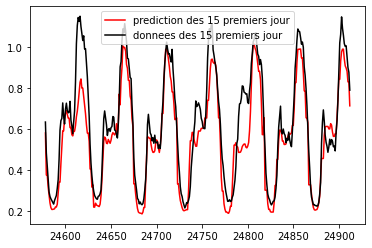

In [14]:
donne_dec=[]
for i in range(len(df['Instant'][-336:-1])):
    donne_dec.append([df['Instant'][i],df['TempMean'][i],df['Precip'][i],df2['WindSpeed'][i],df2['TempMin'][i],df2['TempMax'][i]])

scal_donne_dec=StandardScaler()
Scaler_donne_dec = scal_donne_dec.fit(donne_dec)
donne_dec_scaled = scal_donne_dec.transform(donne_dec)

Pred=neigh3.predict(donne_dec_scaled)
plt.plot(df['Time'][-336:-1],Pred,'r',label='prediction des 15 premiers jour')
plt.plot(df['Time'][-336:-1],df['mean'][-336:-1],'k',label='donnees des 15 premiers jour')
plt.legend()
plt.show()

On prédit les 15 premiers jours de décembre avec ce modèle et on le compare avec les donées réelles pour se rendre compte. On a des approximations aux maximas et aux zone de perturbartions au milieu de la journée. Cependant on a le sentiment que les zones d'approximation au milieu de l ajournée sont mieux appréhender.

Dans un nouveau but d'amélioration, on va vouloir preprocess nos données et notamment jouer sur le fait que on étudie des cycles. L'idée est donc d'agir sur les instants pour témoigner de la proximité entre les derniers heures de la nuit d'un jur (instant 46-47-48) et les les premieres heures du matin du jour suivant (instant 0-1-2-3). Pour cela la première expérimentation est de partir sur l'utilisation de spline, qui se fait par un modèle de Pipeline

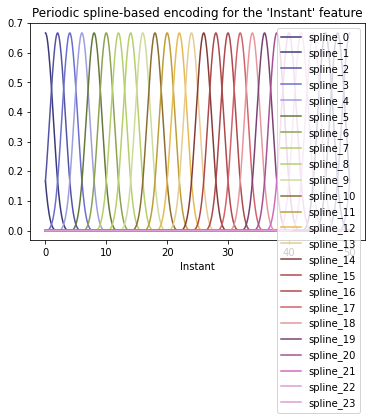

In [15]:
from sklearn.preprocessing import SplineTransformer

def periodic_spline_transformer(period, n_splines=None, degree=3):
    if n_splines is None:
        n_splines = period
    n_knots = n_splines + 1  # periodic and include_bias is True
    return SplineTransformer(
        degree=degree,
        n_knots=n_knots,
        knots=np.linspace(0, period, n_knots).reshape(n_knots, 1),
        extrapolation="periodic",
        include_bias=True,
    )

instant_df = pd.DataFrame(
    np.linspace(0, 50, 1000).reshape(-1, 1),
    columns=["Instant"],
)
splines = periodic_spline_transformer(48, n_splines=24).fit_transform(instant_df)
splines_df = pd.DataFrame(
    splines,
    columns=[f"spline_{i}" for i in range(splines.shape[1])],
)

pd.concat([instant_df, splines_df], axis="columns").plot(x="Instant",cmap=plt.cm.tab20b)
_ = plt.title("Periodic spline-based encoding for the 'Instant' feature")

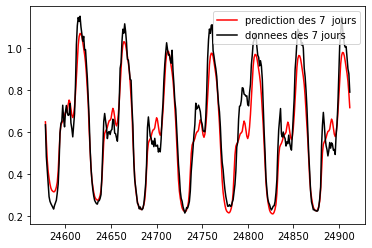

In [16]:
Y=pd.concat([df['mean'][1:m*48-1],df['mean'][n*48:(n+m)*48-1]])

alphas = np.logspace(-6, 6, 25)

cyclic_spline_transformer = ColumnTransformer(
    transformers=[
        ("cyclic_hour", periodic_spline_transformer(48, n_splines=24), ["Instant"]),
    ],
    remainder=MinMaxScaler(),
)
cyclic_spline_linear_pipeline = make_pipeline(
    cyclic_spline_transformer,
    RidgeCV(alphas=alphas),
)

data=pd.concat([df.drop(['mean','WindSpeedMaxS','WindSpeedMaxG','Posan','Time',],axis=1)[1:m*48-1],df.drop(['mean','WindSpeedMaxS','WindSpeedMaxG','Posan','Time',],axis=1)[n*48:(n+m)*48-1]], ignore_index=True)

data
cyclic_spline_linear_pipeline.fit(data, Y)
cyclic_spline_linear_predictions = cyclic_spline_linear_pipeline.predict(df.drop(['mean','WindSpeedMaxS','WindSpeedMaxG','Posan','Time'],axis=1)[-336:-1])


plt.plot(df['Time'][-336:-1],cyclic_spline_linear_predictions,'r',label='prediction des 7  jours')
plt.plot(df['Time'][-336:-1],df['mean'][-336:-1],'k',label='donnees des 7 jours')
plt.legend()
plt.show()

On prédit à nouveau les 15 premiers jours de décembre avec ce modèle et on le compare avec les donées réelles pour se rendre compte. On observe que les maximas sont vraiment mieux appréhendés. 

In [17]:
cyclic_spline_linear_pipeline = make_pipeline(
    cyclic_spline_transformer,
    RidgeCV(alphas=alphas),
)

from sklearn.model_selection import train_test_split
#Séparation des données en 4 listes avec des données test de 40%
X_train, X_test, Y_train, Y_test = train_test_split(data,Y,test_size=0.2)

cyclic_spline_linear_pipeline.fit(X_train,Y_train)
print(cyclic_spline_linear_pipeline.score(X_test,Y_test))


0.9116071337983748


On obtient cependant un score plus faible que pour KNN (0.91 contre 0.95)...L'idée est donc bonne au niveau de l'allure de la courbe mais le modèle KNN rest plus performant; On va donc essayer d'appliquer cette idée de cyce au modèle KNN

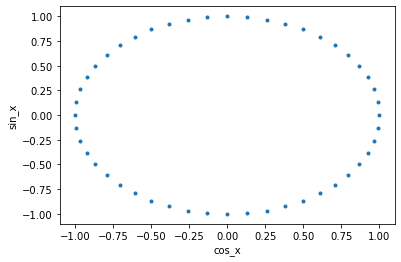

In [18]:
df["x_norm"] = 2 * math.pi * df["Instant"] / df["Instant"].max()

df["cos_x"] = np.cos(df["x_norm"])

df["sin_x"] = np.sin(df["x_norm"])

df_selected = df[["cos_x","sin_x"]]

plt.plot(df['cos_x'][:48],df['sin_x'][:48],'.')
plt.xlabel('cos_x')
plt.ylabel('sin_x')
plt.show()

Pour cela on transforme les instants en données comprises entre 0 et 2*pi et on crée 2 nouvelles donées sin x et cos x. Ainsi la fin de la jurnée se trouve vraiment proche du début du jour suivant en terme de valeurs

In [19]:

n=270
m=75

x=[]
for i in range(1,m*48-1):
    x.append([df['cos_x'][i],df['sin_x'][i],df['TempMean'][i],df['Precip'][i],df['WindSpeed'][i],df['TempMin'][i],df['TempMax'][i]])
for i in range(n*48,(n+m)*48-1):
    x.append([df['cos_x'][i],df['sin_x'][i],df['TempMean'][i],df['Precip'][i],df['WindSpeed'][i],df['TempMin'][i],df['TempMax'][i]])

Y=np.concatenate((np.array(df['mean'][1:m*48-1]),np.array(df['mean'][n*48:(n+m)*48-1])))

neigh=KNeighborsRegressor(n_neighbors=3, weights="uniform")

scal=StandardScaler()
Scaler = scal.fit(x)
x_scaled = Scaler.transform(x)

X_train, X_test, Y_train, Y_test = train_test_split(x_scaled,Y,test_size=0.2)

neigh.fit(X_train,Y_train)

print(neigh.score(X_test,Y_test))

0.9601225862508519


On garde donc les mêmes features en changeant just Instant en sin x et cos x. On obtient un score plus haut que ce qu'on avait auparavant de 0.96 

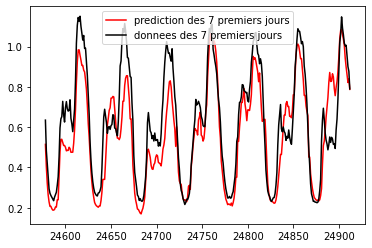

In [20]:
donne_dec=[]
for i in range(len(df['Instant'][-336:-1])):
    donne_dec.append([df['cos_x'][i],df['sin_x'][i],df['TempMean'][i],df['Precip'][i],df['WindSpeed'][i],df['TempMin'][i],df['TempMax'][i]])

scal_donne_dec=StandardScaler()
Scaler_donne_dec = scal_donne_dec.fit(donne_dec)
donne_dec_scaled = scal_donne_dec.transform(donne_dec)

Pred=neigh.predict(donne_dec_scaled)
plt.plot(df['Time'][-336:-1],Pred,'r',label='prediction des 7 premiers jours')
plt.plot(df['Time'][-336:-1],df['mean'][-336:-1],'k',label='donnees des 7 premiers jours')
plt.legend()
plt.show()

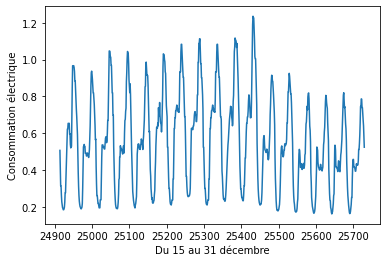

In [21]:
df2["x_norm"] = 2 * math.pi * df2["Instant"] / df2["Instant"].max()

df2["cos_x"] = np.cos(df2["x_norm"])

df2["sin_x"] = np.sin(df2["x_norm"])

df2_selected = df2[["cos_x","sin_x"]]

donne_dec=[]
for i in range(len(df2['Instant'])):
    donne_dec.append([df2['cos_x'][i],df2['sin_x'][i],df2['TempMean'][i],df2['Precip'][i],df2['WindSpeed'][i],df2['TempMin'][i],df2['TempMax'][i]])

scal_donne_dec=StandardScaler()
Scaler_donne_dec = scal_donne_dec.fit(donne_dec)
donne_dec_scaled = scal_donne_dec.transform(donne_dec)

Pred_fin_dec=neigh.predict(donne_dec_scaled)

plt.plot(df2['Time'],Pred_fin_dec)
plt.xlabel('Du 15 au 31 décembre')
plt.ylabel('Consommation électrique')
plt.show()

On garde donc le modèle avec le score le plus haut pour faire nos prévisions pour les 15 derniers jours de décembre

In [22]:
df2['mean']=Pred_fin_dec

df2['mean'].to_csv('Prediction_Grouepe6.csv')

In [25]:


# Fixer les valeurs des hyperparamètres à tester
param_grid = {'n_neighbors':[2,3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]}

# Choisir un score à optimiser, ici l'accuracy (proportion de prédictions correctes)
score = 'accuracy'

y_class = np.where(Y<0.5, 0, 1)

X_train, X_test, y_train, y_test = model_selection.train_test_split(x, y_class, test_size=0.3)# 30% des données dans le jeu de test)

std_scale = preprocessing.StandardScaler().fit(X_train)
X_train_std = std_scale.transform(X_train)
X_test_std = std_scale.transform(X_test)



# Créer un classifieur kNN avec recherche d'hyperparamètre par validation croisée
clf = model_selection.GridSearchCV(
    neighbors.KNeighborsClassifier(), # un classifieur kNN
    param_grid,     # hyperparamètres à tester
    cv=5,           # nombre de folds de validation croisée
    scoring=score   # score à optimiser
)

# Optimiser ce classifieur sur le jeu d'entraînement
clf.fit(X_train_std, y_train)

# Afficher le(s) hyperparamètre(s) optimaux
print("Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:")
print(clf.best_params_)


Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:
{'n_neighbors': 13}


On réalise à la fin une étude pour optimiser le nombre de voisins optimal pour notre modèle KNN choisi. Le nombre optimal est alors prévu à 3